In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Missing colon in file WindowsPath('d:/python/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 162 (' Use the following to set default font to SimHei (黑体) for Chinese support')


In [9]:
# 设置路径和参数
DATASET_DIR = 'data/flower_images'  # 数据集路径
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 50
LEARNING_RATE = 0.0001


In [10]:
# 加载和增强数据
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% 作为验证集
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [11]:
# 加载预训练的 MobileNetV2 模型
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 冻结 base_model 的所有层

# 构建新的顶层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # 使用 Dropout 防止过拟合
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 构建完整的模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 提前停止的回调函数，监控验证损失，容忍5个不改进的轮次
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [12]:
# 训练模型，加入 EarlyStopping 回调函数
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping]
)

d:\python\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 66s 687ms/step - accuracy: 0.5000 - loss: 1.2761 - val_accuracy: 0.7912 - val_loss: 0.5727
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 31s 350ms/step - accuracy: 0.7812 - loss: 0.7601

d:\python\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.7601 - val_accuracy: 0.8519 - val_loss: 0.4127
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 62s 677ms/step - accuracy: 0.8046 - loss: 0.5800 - val_accuracy: 0.8253 - val_loss: 0.4926
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.6163 - val_accuracy: 0.7778 - val_loss: 0.5638
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 61s 673ms/step - accuracy: 0.8367 - loss: 0.4717 - val_accuracy: 0.8537 - val_loss: 0.4717
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.3958 - val_accuracy: 0.8148 - val_loss: 0.3853
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 62s 683ms/step - accuracy: 0.8406 - loss: 0.4387 - val_accuracy: 0.8494 - val_loss: 0.4354
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.4545 - val_accuracy: 0.8889 - val_loss: 0.4148
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 62s 683ms/step - accuracy: 0.8425 - loss: 0.4088 - val_accuracy: 0.8480 - val_loss

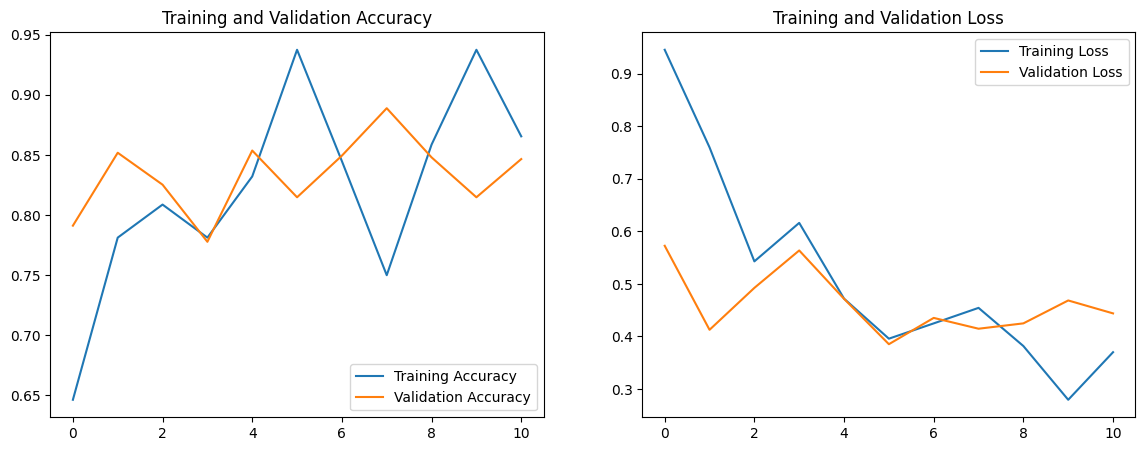

In [13]:
# 可视化训练过程
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # 绘制训练和验证准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # 绘制训练和验证损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training(history)


In [14]:
# 保存模型
model.save('models/flower_model_updated.h5')